# Md. Tanjirul Islam 17-34764-2

## Import TensorFlow and other libraries

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Jobayer hayder mishal  17-33104-1 

## Find available DataSet & Download and explore the dataset

Download DataSet

In [38]:
import pathlib #import Object-oriented filesystem paths
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz" #tensorflow datasate
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)#move into folder
data_dir = pathlib.Path(data_dir)#initial path

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [39]:
image_count = len(list(data_dir.glob('*/*.jpg')))#floder ar jpg file count
print(image_count)#print count

3670


Here are some roses:

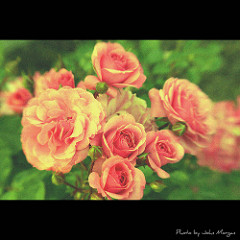

In [40]:
roses = list(data_dir.glob('roses/*')) #image list for jpg rese folder
PIL.Image.open(str(roses[10]))#10 index image show

And some tulips:

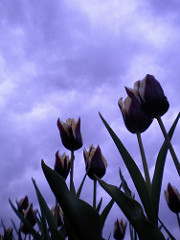

In [41]:
tulips = list(data_dir.glob('tulips/*'))#image list for jpg tulips folder
PIL.Image.open(str(tulips[20]))#20 index image show

# MD Tawheed Anjum 17-34256-1

# Load using keras.preprocessing


### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32 #number of test samples
img_height = 180 #image hieght initiate
img_width = 180 #image width initiate

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory( # will return a tf.data.Dataset
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, #dirrectory name from above
  validation_split=0.2, #means "use 20% of the data for validation
  subset="validation",
  seed=123, #Sets the global random seed.
  image_size=(img_height, img_width), #img size initiate
  batch_size=(batch_size) #batch_size initiate

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


We can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [9]:
class_names = train_ds.class_names #make an class from folder name
print(class_names) #print data

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first 7 images from the training dataset.

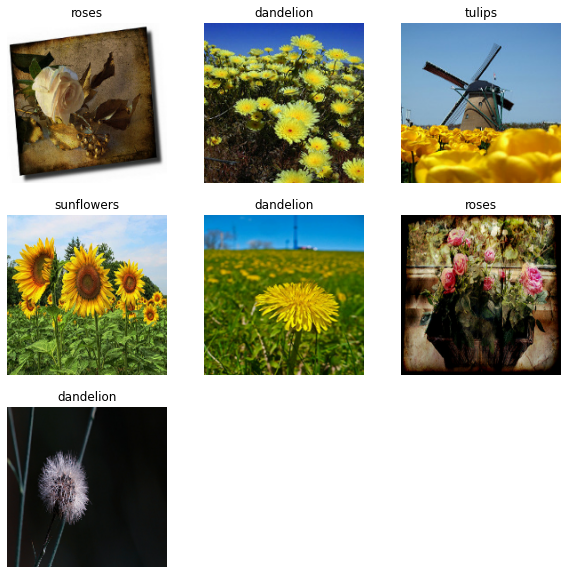

In [10]:
import matplotlib.pyplot as plt #import matplotlib.pyplot library

plt.figure(figsize=(10, 10)) #initiate figure 
for images, labels in train_ds.take(1): 
  for i in range(7): #for loop range 7
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")) #img datatype
    plt.title(class_names[labels[i]]) #make titile as class name
    plt.axis("off") #axis off

train a model using these datasets by passing them to `model.fit` in a moment. 

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape) # print image batch shape
  print(labels_batch.shape) # print label batch shape
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 



## Configure the dataset for performance

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE #initial traininf time

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) #cach value

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255) #comment avobe

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) #creating map
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0] #first batch for test
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))  #print

0.0 0.9993465


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function.

In [15]:
#headen lear
num_classes = 5

model = Sequential([ #define squential model
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),#image resizinf lear
  layers.Conv2D(16, 3, padding='same', activation='relu'),#covution CNN 2D relue = "rectifire liner activation"
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),#flatten the input, Does not affect the batch size
  layers.Dense(128, activation='relu'), # reguler densiley-cnnected NN Layer
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [16]:
model.compile(optimizer='adam', #GPU CPU performance optimize(Gradiyen deicent)
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary



In [17]:
model.summary() #optimize summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [18]:
epochs=10 #train model for 10 times
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 51s 554ms/step - loss: 1.7449 - accuracy: 0.3219 - val_loss: 1.0655 - val_accuracy: 0.5668
Epoch 2/10
92/92 [==============================] - 53s 575ms/step - loss: 1.0511 - accuracy: 0.5725 - val_loss: 0.9702 - val_accuracy: 0.6349
Epoch 3/10
92/92 [==============================] - 53s 572ms/step - loss: 0.8574 - accuracy: 0.6663 - val_loss: 0.9110 - val_accuracy: 0.6458
Epoch 4/10
92/92 [==============================] - 53s 575ms/step - loss: 0.6713 - accuracy: 0.7496 - val_loss: 0.9605 - val_accuracy: 0.6499
Epoch 5/10
92/92 [==============================] - 53s 578ms/step - loss: 0.4795 - accuracy: 0.8341 - val_loss: 1.2111 - val_accuracy: 0.5886
Epoch 6/10
92/92 [==============================] - 60s 651ms/step - loss: 0.3351 - accuracy: 0.8778 - val_loss: 1.2821 - val_accuracy: 0.6403
Epoch 7/10
92/92 [==============================] - 58s 635ms/step - loss: 0.1685 - accuracy: 0.9534 - val_loss: 1.3108 - val_accuracy: 0.6349

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

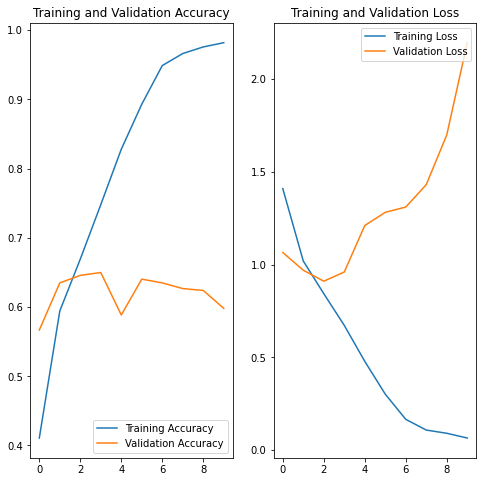

In [19]:
acc = history.history['accuracy'] # to accecss the value in order to avoid key error
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8)) #window size
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy') #title creat
plt.plot(epochs_range, val_acc, label='Validation Accuracy') #another titile
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')  #sub titile
plt.plot(epochs_range, val_loss, label='Validation Loss') #sub titile
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')  #another titile
plt.show() #plot show

## Overfitting

In [20]:
data_augmentation = keras.Sequential( #provides training
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, #error solving
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

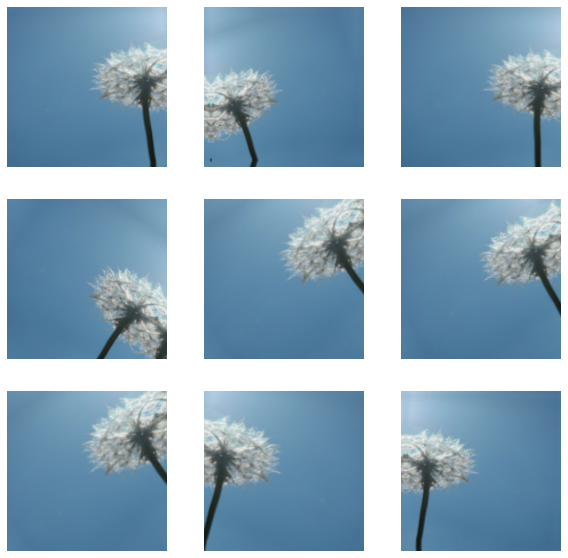

In [21]:
plt.figure(figsize=(10, 10)) #initiat figer
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images) #argumant pass
    ax = plt.subplot(3, 3, i + 1) #matplot index start with 1
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

### Dropout


In [22]:
#check avobe comment
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [23]:
model.compile(optimizer='adam', # again after solving(again check avobe)
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary() # summary show

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [24]:
epochs = 15 #training 15 times
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 60s 646ms/step - loss: 1.4840 - accuracy: 0.3332 - val_loss: 1.1608 - val_accuracy: 0.5232
Epoch 2/15
92/92 [==============================] - 60s 658ms/step - loss: 1.0622 - accuracy: 0.5661 - val_loss: 0.9626 - val_accuracy: 0.6322
Epoch 3/15
92/92 [==============================] - 65s 708ms/step - loss: 0.9690 - accuracy: 0.6223 - val_loss: 0.9010 - val_accuracy: 0.6308
Epoch 4/15
92/92 [==============================] - 65s 707ms/step - loss: 0.8761 - accuracy: 0.6606 - val_loss: 0.8548 - val_accuracy: 0.6608
Epoch 5/15
92/92 [==============================] - 64s 688ms/step - loss: 0.8099 - accuracy: 0.6901 - val_loss: 0.8372 - val_accuracy: 0.6662
Epoch 6/15
92/92 [==============================] - 62s 672ms/step - loss: 0.7806 - accuracy: 0.6997 - val_loss: 0.7702 - val_accuracy: 0.6989
Epoch 7/15
92/92 [==============================] - 86s 933ms/step - loss: 0.7255 - accuracy: 0.7244 - val_loss: 0.7374 - val_accuracy: 0.7098

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

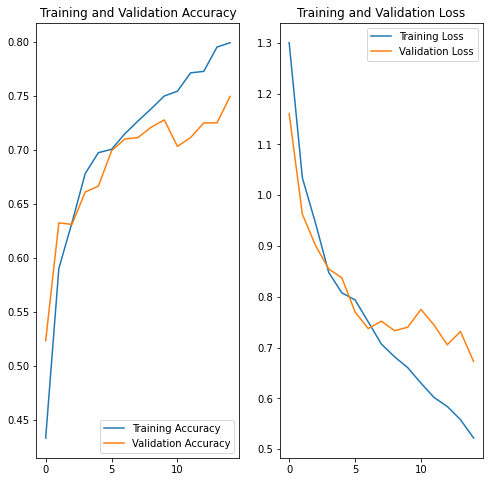

In [25]:
acc = history.history['accuracy'] #again check graph(comment in above)
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# jamiual amin topu 16-32249-2

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

This image most likely belongs to roses with a 63.47 percent confidence.


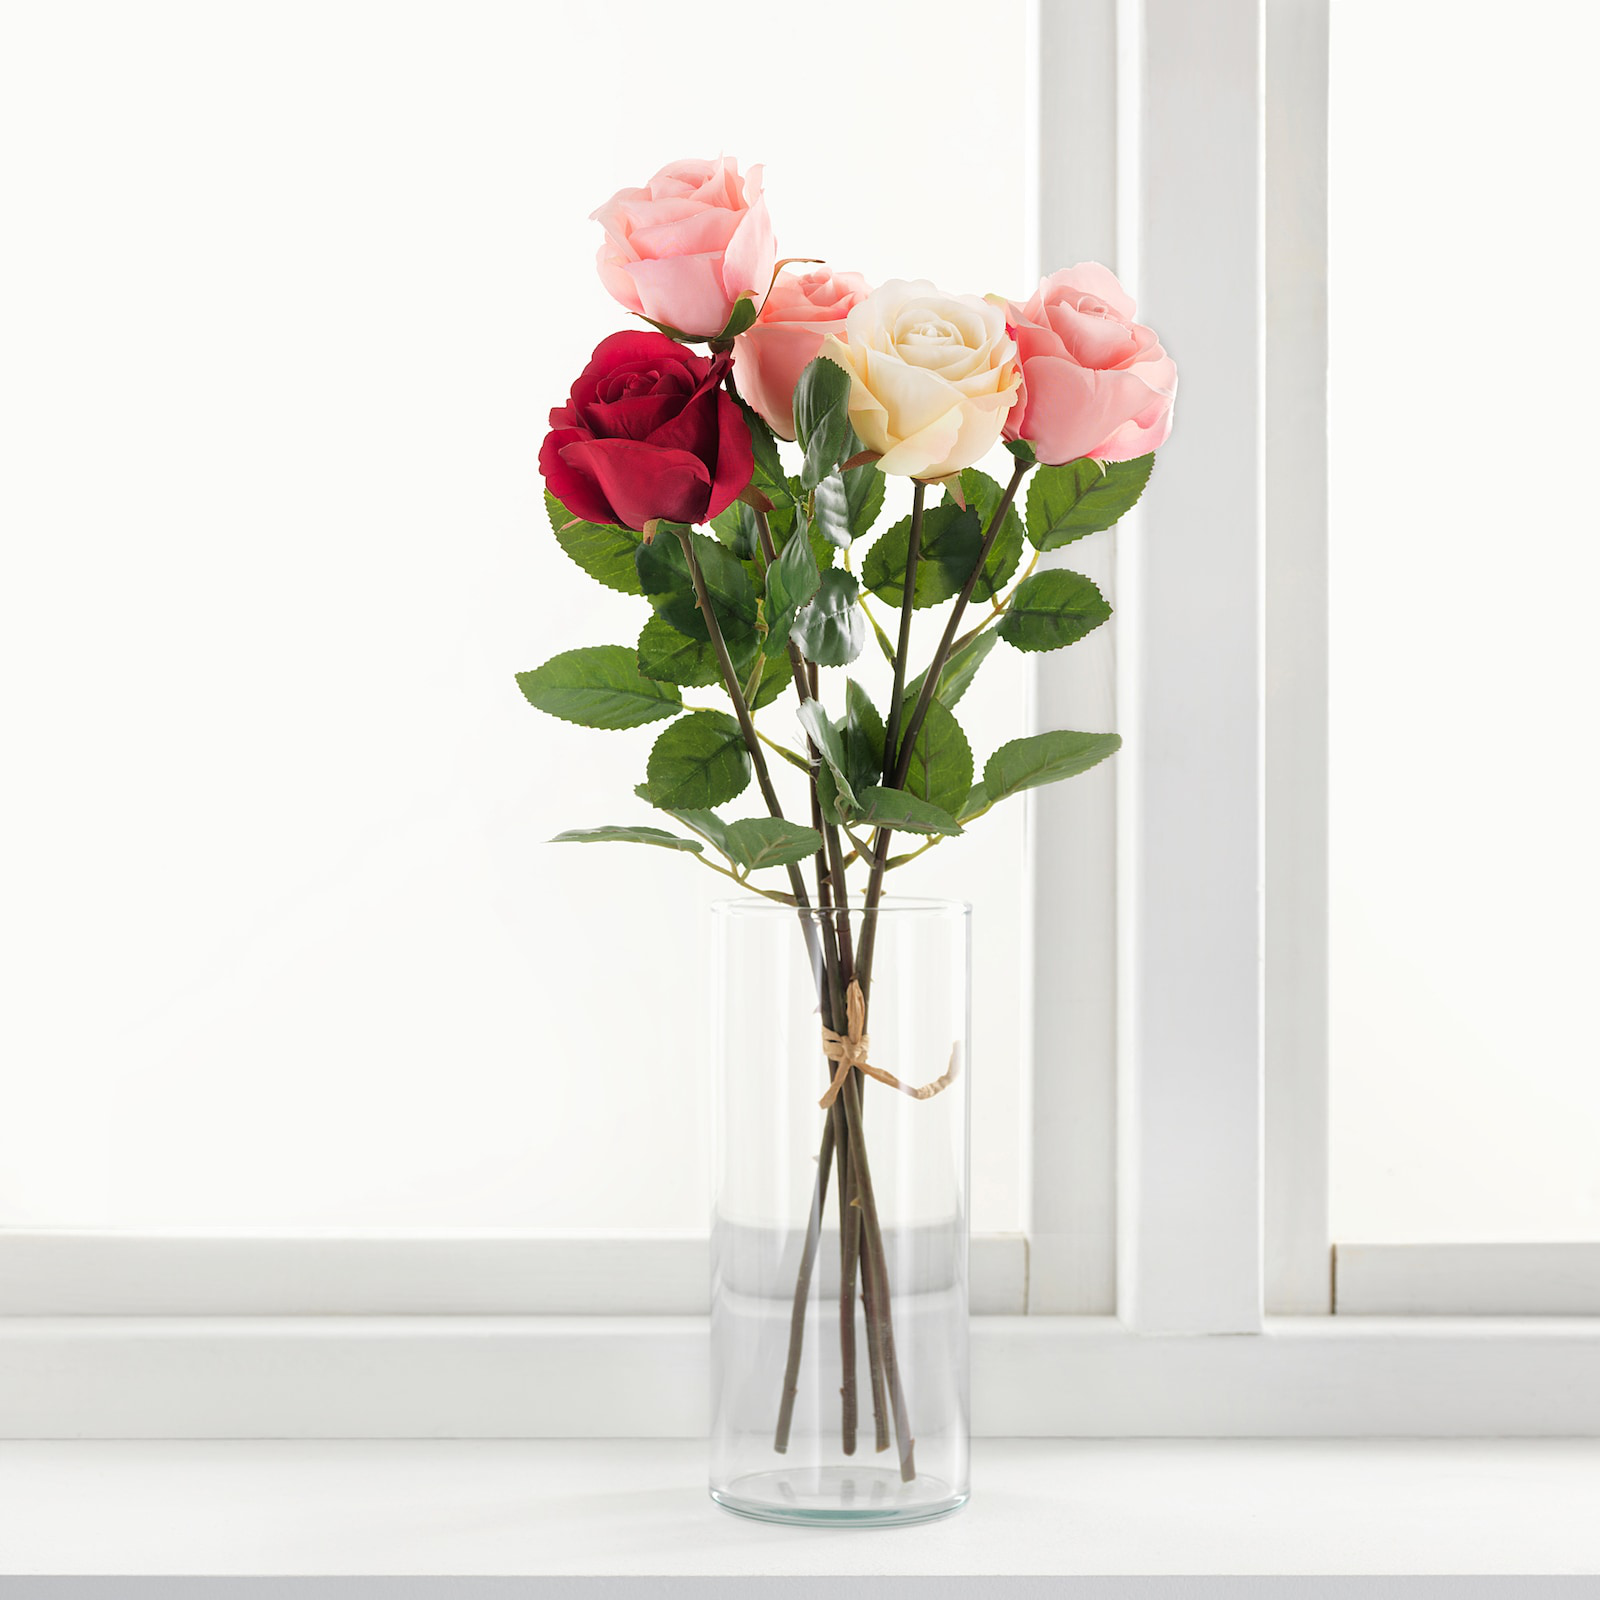

In [35]:
image_url = "https://www.ikea.com/gb/en/images/products/smycka-artificial-flower-rose-red__0902944_PE596726_S5.JPG?f=sg" #testing imageurl
image_path = tf.keras.utils.get_file('test_image', origin=image_url) #get the mage files

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width) #process the height width
)
img_array = keras.preprocessing.image.img_to_array(img) #img in arry
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(   #printing the accuracy
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

PIL.Image.open(image_path) #show the image